<a href="https://colab.research.google.com/github/netaamz/DL-Model-for-Automated-Detection-of-Meniscus-Tears-in-Knee-MRI-Images/blob/main/Single_plane_ConvDTFBN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone: Development of an algorithm for automatic detection of meniscus tears in radiographic images of the knee.

Important note: a pre processing is required, avilable notebook via github

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:

!pip install tensorflow
!pip install keras
!pip install sklearn
!pip install opencv-python
!pip install matplotlib
!pip install numpy

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


## Data import

**Data from [MRNet](https://stanfordmlgroup.github.io/competitions/mrnet/):**
* Images of 1370 knee MRI exams performed at Stanford University Medical Center. The dataset contains 1,104 (80.6%) abnormal exams,  with 319 (23.3%) ACL tears and 508 (37.1%) meniscal tears; labels were obtained through manual extraction from clinical reports.
* train set: consists of 1130 MRI images from coronal, sagittal and transverse planes
* validation set: consists of 120 MRI images from coronal, sagittal and transverse planes


Connect google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Data generation for meniscus
The dataset contains 17 x 256 x 256 images. Since middle images are the most useful, only 3 middle slides in the series are retained.


In [ ]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
def data_gen(dataset_type, plane, diagnosis):
    '''this function gets the data from the extracted datset'''

    if dataset_type == 'train':
        go = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/train_transform17d'
    else:
        go = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/valid_transform17d'

    plane_dir = f'{go}/{plane}.npy'

    data = np.load(plane_dir)
    label_path = f'/content/drive/My Drive/miniscus data set/MRNet-v1.0/{dataset_type}-{diagnosis}.csv'

    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])

    return(data, label_data)


Note that training data for all planes are the same. Only labels are different.

Coronal & sagittial

In [ ]:
# generate training input
coronal_mensicus, coronal_mensicus_label = data_gen('train', 'coronal/extracted_images', 'meniscus')
# generate validation
coronal_mensicus_val, coronal_mensicus_label_val  = data_gen('valid', 'coronal/extracted_images', 'meniscus')

In [ ]:
sagittal_mensicus, sagittal_mensicus_label = data_gen('train', 'sagittal/extracted_images', 'meniscus')
# generate validation
sagittal_mensicus_val, sagittal_mensicus_label_val  = data_gen('valid', 'sagittal/extracted_images', 'meniscus')

In [ ]:
# Assuming axial_mensicus_label is initially a list, convert it to a NumPy array
coronal_mensicus= np.array(coronal_mensicus)
coronal_mensicus_label = np.array(coronal_mensicus_label)
sagittal_mensicus_label = np.array(sagittal_mensicus_label)


In [ ]:
coronal_mensicus = np.transpose(coronal_mensicus, (0, 2, 3, 1)).astype('float32')
coronal_mensicus_val = np.transpose(coronal_mensicus_val, (0, 2, 3, 1)).astype('float32')

In [ ]:
# Convert input data to float32 and print shapes to check

sagittal_mensicus = np.transpose(sagittal_mensicus, (0, 2, 3, 1)).astype('float32')
sagittal_mensicus_val = np.transpose(sagittal_mensicus_val, (0, 2, 3, 1)).astype('float32')

In [ ]:
print(coronal_mensicus.shape)
print(coronal_mensicus.ndim)
print(sagittal_mensicus.shape)
print(coronal_mensicus_label.shape)
print(sagittal_mensicus_label.shape)

(1130, 256, 256, 17)
4
(1130, 256, 256, 17)
(1130,)
(1130,)


## Model Architecture

The model is designed to classify grayscale MRI images for detecting normal menisci or meniscus tears. The input images, resized to 256x256xs 17 in this case, undergo preprocessing steps, including splicing and applying a White Top Hat filter to enhance features.
* The preprocessed images are then fed into a conv2D exctracting the features, to feature map of 256x256x3 that passed into the pre-trained DenseNet121
architecture, which has been modified to exclude its top classification layers.
* The DenseNet121 model processes the input and outputs feature maps, which are subsequently passed through a Global Average Pooling layer, reducing the spatial dimensions into a 1D vector.
* A Batch Normalization layer is applied to stabilize the network and improve learning performance.
* The feature vector is then fed into a Dense Layer with 1024 units and ReLU activation to extract high-level features, followed by a Dropout Layer to mitigate overfitting.
A second Dense Layer, also with 512 units and ReLU activation, further refines the feature space.
* Finally, the model outputs predictions through a Dense Layer with 2 units and sigmoid activation, representing the probabilities of the two classes (normal or meniscus tear).

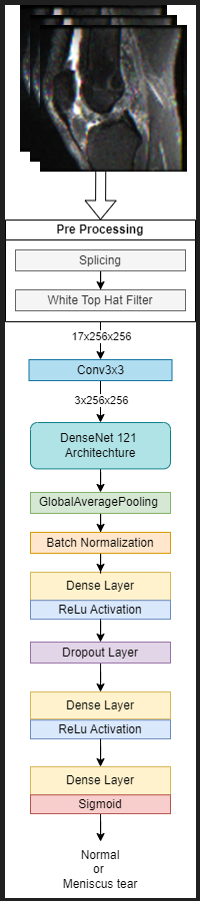

##  Hyperparameters
define hyper parameters for training

In [ ]:
# Ensure that coronal_mensicus and sagittal_mensicus are NumPy arrays
coronal_mensicus = np.asarray(coronal_mensicus)
sagittal_mensicus = np.asarray(sagittal_mensicus)
coronal_mensicus_val = np.asarray(coronal_mensicus_val)
sagittal_mensicus_val = np.asarray(sagittal_mensicus_val)

# Labels should also be NumPy arrays
coronal_mensicus_label = np.asarray(coronal_mensicus_label)
coronal_mensicus_label_val = np.asarray(coronal_mensicus_label_val)
sagittal_mensicus_label=np.asarray(sagittal_mensicus_label)
sagittal_mensicus_label_val=np.asarray(sagittal_mensicus_label_val)

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, Reshape, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint

# Hyperparameters
IMAGE_SIZE = 256
IMAGE_DEPTH = 17
CHANNEL = 1
NUM_CLASSES = 1
batch_size = 64
nb_epoch = 50
dropout = 0.4
lr = 1e-3

def create_model(input_shape, NUM_CLASSES, dropout):
    input_tensor = Input(shape=input_shape)

    # Apply 3D Convolution to reduce depth complexity while preserving spatial dimensions
    x = Conv2D(filters=3, kernel_size=(3, 3), activation='relu', padding='same')(input_tensor)

    # Load DenseNet with the modified input shape
    base_model = DenseNet121(weights='imagenet', include_top=False, pooling=None, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    # Pass reshaped input to DenseNet
    x = base_model(x)

    # Add further layers
    x = GlobalAveragePooling2D()(x)
    x= BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(512, activation='relu')(x)
    output = Dense(NUM_CLASSES, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=input_tensor, outputs=output)

    # Optionally freeze DenseNet layers
    for layer in base_model.layers:
        layer.trainable = False

    return model

if __name__ == '__main__':
    # Create the model
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_DEPTH)  # ( 256, 256,17, 1)
    print("input shape:",input_shape)
    print(coronal_mensicus.shape)
    print(coronal_mensicus.ndim)
    print(coronal_mensicus.dtype)
    model_coronal = create_model(input_shape, NUM_CLASSES, dropout)
    model_sagittal = create_model(input_shape, NUM_CLASSES, dropout)

    # Compile both models
    optimizer = SGD(learning_rate=lr, momentum=0.9)

    optimizer1 = SGD(learning_rate=lr, momentum=0.9)
    model_coronal.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model_coronal.summary()
    model_sagittal.compile(optimizer=optimizer1, loss='binary_crossentropy', metrics=['accuracy'])
    model_sagittal.summary()
    # Set up checkpoints for both models
    checkpoint_coronal = ModelCheckpoint("bestmodel_coronal.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    checkpoint_sagittal = ModelCheckpoint("bestmodel_sagittal.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

    # Callbacks list
    callbacks_coronal = [checkpoint_coronal]
    callbacks_sagittal = [checkpoint_sagittal]

    # Train the coronal model

        # # Train the sagittal model
    sagittal_mensicus_reshaped = sagittal_mensicus.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, IMAGE_DEPTH)
    sagittal_mensicus__val_reshaped=sagittal_mensicus_val.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, IMAGE_DEPTH)
    history_sagittal = model_sagittal.fit(sagittal_mensicus_reshaped, sagittal_mensicus_label,
                                          batch_size=batch_size,
                                          epochs=nb_epoch,
                                          shuffle=True,
                                          verbose=1,
                                          validation_data=(sagittal_mensicus__val_reshaped, sagittal_mensicus_label_val),
                                          callbacks=callbacks_sagittal)
    coronal_mensicus_reshaped = coronal_mensicus.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, IMAGE_DEPTH)
    coronal_mensicus__val_reshaped=coronal_mensicus_val.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, IMAGE_DEPTH)
    history_coronal = model_coronal.fit(coronal_mensicus_reshaped, coronal_mensicus_label,
                                            batch_size=batch_size,
                                            epochs=nb_epoch,
                                            shuffle=True,
                                            verbose=1,
                                            validation_data=(coronal_mensicus__val_reshaped, coronal_mensicus_label_val),
                                            callbacks=callbacks_coronal)




input shape: (256, 256, 17)
(1130, 256, 256, 17)
4
float32
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 17)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 3)         │             462 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 8, 8, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,616,975 (32.87 MB)

 Trainable params: 1,577,423 (6.02 MB)

 Non-trainable params: 7,039,552 (26.85 MB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 256, 256, 17)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 3)         │             462 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 8, 8, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,616,975 (32.87 MB)

 Trainable params: 1,577,423 (6.02 MB)

 Non-trainable params: 7,039,552 (26.85 MB)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4865 - loss: 0.7455   
Epoch 1: val_accuracy improved from -inf to 0.56667, saving model to bestmodel_sagittal.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.4900 - loss: 0.7438 - val_accuracy: 0.5667 - val_loss: 0.9889
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.6798 - loss: 0.6481
Epoch 2: val_accuracy improved from 0.56667 to 0.58333, saving model to bestmodel_sagittal.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 533ms/step - accuracy: 0.6778 - loss: 0.6492 - val_accuracy: 0.5833 - val_loss: 0.7709
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.6180 - loss: 0.6581
Epoch 3: val_accuracy did not improve from 0.58333
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 487ms/step - accuracy: 0.6178 - loss: 0.6580 - val_accuracy: 0.5750 - val_loss: 0.7651
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.6785 - loss: 0.6274
Epoch 4: val_accuracy did not improve from 0.58333
18/18 ━━━━━━

## Train

## Predict

In [13]:

predictions_valid_coronal = model_coronal.predict(coronal_mensicus_val, batch_size=batch_size, verbose=1)
predictions_valid_sagittal = model_sagittal.predict(sagittal_mensicus_val, batch_size=batch_size, verbose=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 9s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step


In [14]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import log_loss,confusion_matrix

score_coronal = log_loss(coronal_mensicus_label_val, predictions_valid_coronal)
score_sagittal = log_loss(sagittal_mensicus_label_val, predictions_valid_sagittal)



# Threshold predictions: Convert probabilities to binary labels (0 or 1)
threshold = 0.5
predictions_valid_coronal_binary = (predictions_valid_coronal > threshold).astype(int)
predictions_valid_sagittal_binary = (predictions_valid_sagittal > threshold).astype(int)

# Calculate accuracy
coronal_acc = accuracy_score(coronal_mensicus_label_val, predictions_valid_coronal_binary)
sagittal_acc = accuracy_score(sagittal_mensicus_label_val, predictions_valid_sagittal_binary)

# Optionally, calculate precision and recall
coronal_precision = precision_score(coronal_mensicus_label_val, predictions_valid_coronal_binary)
sagittal_precision = precision_score(sagittal_mensicus_label_val, predictions_valid_sagittal_binary)

coronal_recall = recall_score(coronal_mensicus_label_val, predictions_valid_coronal_binary)
sagittal_recall = recall_score(sagittal_mensicus_label_val, predictions_valid_sagittal_binary)

coronal_con= confusion_matrix(coronal_mensicus_label_val, predictions_valid_coronal_binary)
sagittal_con= confusion_matrix(sagittal_mensicus_label_val, predictions_valid_sagittal_binary)
# Output the results
print(f"Coronal Log Loss: {score_coronal}")
print(f"Sagittal Log Loss: {score_sagittal}")
print(f"Coronal Accuracy: {coronal_acc}")
print(f"Sagittal Accuracy: {sagittal_acc}")
print(f"Coronal Precision: {coronal_precision}")
print(f"Sagittal Precision: {sagittal_precision}")
print(f"Coronal Recall: {coronal_recall}")
print(f"Sagittal Recall: {sagittal_recall}")

print("Coronal Confusion Matrix:")
print(coronal_con)
print("Sagittal Confusion Matrix:")
print(sagittal_con)



Coronal Log Loss: 0.8251803135911281
Sagittal Log Loss: 0.9914280191124859
Coronal Accuracy: 0.5666666666666667
Sagittal Accuracy: 0.49166666666666664
Coronal Precision: 0.5
Sagittal Precision: 0.2631578947368421
Coronal Recall: 0.19230769230769232
Sagittal Recall: 0.09615384615384616
Coronal Confusion Matrix:
[[58 10]
 [42 10]]
Sagittal Confusion Matrix:
[[54 14]
 [47  5]]


## Evaluate

In [15]:
import numpy as np
def calculate_accuracy(ypred, ytest):
    '''calculate accuracy and misclassification'''
    total = 0
    accurate = 0
    accurateindex = []
    wrongindex = []

    for i in range(len(ypred)):
        if ypred[i]== ytest[i]:
            accurate += 1
            accurateindex.append(i)
        else:
            wrongindex.append(i)
        total += 1

    accuracy = round(accurate / total * 100, 3)
    return total, accurate, total - accurate, accuracy, accurateindex, wrongindex

In [16]:




# Coronal plane accuracy
total_coronal, accurate_coronal, wrong_coronal, accuracy_coronal, accurateindex_coronal, wrongindex_coronal = calculate_accuracy(predictions_valid_coronal_binary, coronal_mensicus_label_val)
print('Coronal - Total test data:', total_coronal, '\tAccurately predicted data:', accurate_coronal, '\tWrongly predicted data:', wrong_coronal)
print('Coronal Accuracy:', accuracy_coronal, '%')

# Sagittal plane accuracy
total_sagittal, accurate_sagittal, wrong_sagittal, accuracy_sagittal, accurateindex_sagittal, wrongindex_sagittal = calculate_accuracy(predictions_valid_sagittal_binary, sagittal_mensicus_label_val)
print('Sagittal - Total test data:', total_sagittal, '\tAccurately predicted data:', accurate_sagittal, '\tWrongly predicted data:', wrong_sagittal)
print('Sagittal Accuracy:', accuracy_sagittal, '%')


Coronal - Total test data: 120 	Accurately predicted data: 68 	Wrongly predicted data: 52
Coronal Accuracy: 56.667 %
Sagittal - Total test data: 120 	Accurately predicted data: 59 	Wrongly predicted data: 61
Sagittal Accuracy: 49.167 %


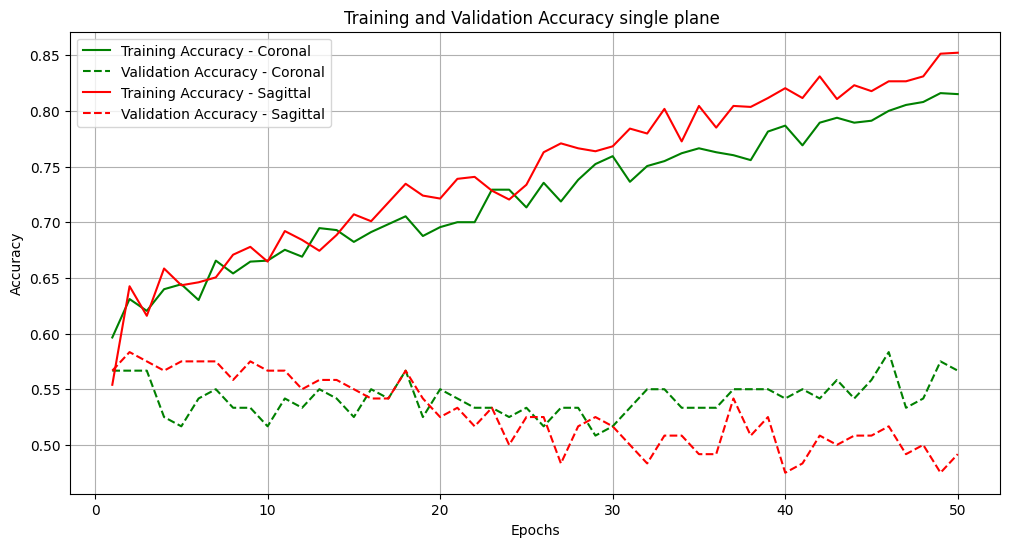

<Figure size 640x480 with 0 Axes>

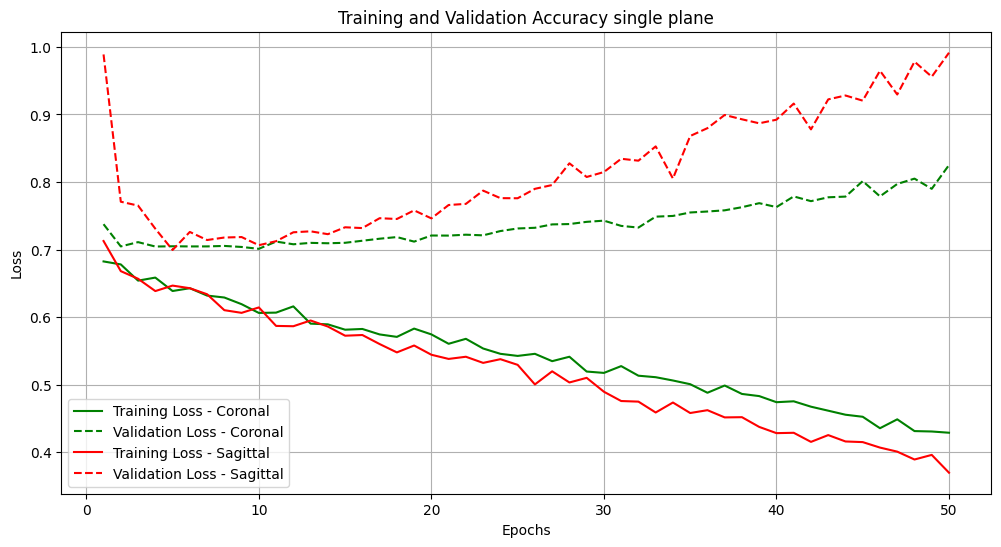

In [17]:
# Evaluating Accuracy and Loss for the three planes: axial, coronal, and sagittal
%matplotlib inline
import matplotlib.pyplot as plt

# Coronal metrics
acc_coronal = history_coronal.history['accuracy']
val_acc_coronal = history_coronal.history['val_accuracy']
loss_coronal = history_coronal.history['loss']
val_loss_coronal = history_coronal.history['val_loss']

#Sagittal metrics
acc_sagittal = history_sagittal.history['accuracy']
val_acc_sagittal = history_sagittal.history['val_accuracy']
loss_sagittal = history_sagittal.history['loss']
val_loss_sagittal = history_sagittal.history['val_loss']
epochs = range(1, len(acc_coronal) + 1)
# Plot training and validation accuracy for each plane
plt.figure(figsize=(12, 6))

plt.plot(epochs, acc_coronal, 'g', label='Training Accuracy - Coronal')
plt.plot(epochs, val_acc_coronal, 'g--', label='Validation Accuracy - Coronal')
plt.plot(epochs, acc_sagittal, 'r', label='Training Accuracy - Sagittal')
plt.plot(epochs, val_acc_sagittal, 'r--', label='Validation Accuracy - Sagittal')

plt.title(f'Training and Validation Accuracy single plane ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(f'Training and Validation Accuracy single plane.png')

plt.figure()

# Plot training and validation loss for each plane
plt.figure(figsize=(12, 6))

plt.plot(epochs, loss_coronal, 'g', label='Training Loss - Coronal')
plt.plot(epochs, val_loss_coronal, 'g--', label='Validation Loss - Coronal')
plt.plot(epochs, loss_sagittal, 'r', label='Training Loss - Sagittal')
plt.plot(epochs, val_loss_sagittal, 'r--', label='Validation Loss - Sagittal')

plt.title(f'Training and Validation Accuracy single plane')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(f'Training and Validation Loss single plane.png')

plt.show()


save the models in a keras file

In [18]:

model_coronal.save("model_coronal.keras")
model_sagittal.save("model_sagittal.keras")

In [19]:
from google.colab import files
files.download('model_coronal.keras')
files.download("model_sagittal.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
from google.colab import files
files.download("Training and Validation Accuracy single plane.png")
files.download("Training and Validation Loss single plane.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>